In [223]:
# !pip install eurostat
# !pip uninstall xgboost
# !pip install scikit-learn

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Use local eurostat package instead of original package
import sys
sys.path.insert(0, 'C:\\Users\\digval\\Documents\\eurostat\\eurostat')
import eurostat

import numpy as np

import xgboost as xgb
from sklearn.metrics  import mean_squared_error

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Show all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr" # change to all, to show all

# Ethanol Trade

Analyis of trade prices and quantities of final products and platforms according to [Eurostat Trade Data](https://ec.europa.eu/eurostat/databrowser/view/DS-045409__custom_7004279/default/table?lang=en)

## Initial EDA

In [2]:
code = 'DS-045409'

# get table columns (parameters)
pars = eurostat.get_pars(code)
pars

['freq', 'reporter', 'partner', 'product', 'flow', 'indicators']

In [3]:
@interact
def unique(Select_Column=pars): 
    print(f'Unique {Select_Column} values:')
    # print unique values (maximum 50)
    print(eurostat.get_par_values(code, Select_Column)[:50])

interactive(children=(Dropdown(description='Select_Column', options=('freq', 'reporter', 'partner', 'product',…

In [7]:
# Filter
my_filter_pars = {
    # Months
    'freq': 'M',
    # Individual Countries + EU + EU27
    'reporter' : ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES',
       'FI', 'FR', 'GB', 'UK', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV',
       'MT', 'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK'], 
    # World
    'partner' : ['WORLD'],
    # Select ethanol, 'lactic acid', 'succinic acid'
    'product' : ['2207', '291811',  '29171920'],
    # Flow doesnt need filtering
    'flow' : ['1'], 
    'indicators': ['QUANTITY_IN_100KG', 'VALUE_IN_EUROS']
}

data = eurostat.get_data_df(code, format="obs-row", flags=True, filter_pars=my_filter_pars)
data.head()

,freq,reporter,partner,product,flow,indicators,TIME_PERIOD,OBS_VALUE,flags
0,M,EU,WORLD,2207,1,QUANTITY_IN_100KG,1988-01,249569.0,
1,M,EU,WORLD,2207,1,VALUE_IN_EUROS,1988-01,13003452.0,
2,M,EU,WORLD,291811,1,QUANTITY_IN_100KG,1988-01,15036.0,
3,M,EU,WORLD,291811,1,VALUE_IN_EUROS,1988-01,2012587.0,
4,M,AT,WORLD,2207,1,QUANTITY_IN_100KG,1988-01,NaN,:


In [8]:
data = data.drop("freq" ,axis = 1)

In [9]:
data.dtypes

reporter       object
partner        object
product        object
flow           object
indicators     object
TIME_PERIOD    object
OBS_VALUE      object
flags          object
dtype: object

In [10]:
data.OBS_VALUE = data.OBS_VALUE.astype(float) #float to include NaNs
data.TIME_PERIOD = pd.to_datetime(data.TIME_PERIOD)

In [11]:
data.describe()

,TIME_PERIOD,OBS_VALUE
count,74304,4.052900e+04
mean,2005-12-15 22:59:59.999999872,1.765429e+06
min,1988-01-01 00:00:00,0.000000e+00
25%,1996-12-24 06:00:00,1.713000e+03
50%,2005-12-16 12:00:00,3.601800e+04
75%,2014-12-08 18:00:00,4.147580e+05
max,2023-12-01 00:00:00,2.606474e+08
std,NaN,8.265797e+06


In [12]:
data.drop(['TIME_PERIOD','OBS_VALUE'], axis = 1).describe()

,reporter,partner,product,flow,indicators,flags
count,74304,74304,74304,74304,74304,74304
unique,29,1,3,1,2,2
top,HR,WORLD,2207,1,QUANTITY_IN_100KG,
freq,2592,74304,25056,74304,37152,40529


I want know the missing values that exist:
* per reporter
* per flow
* per indicator
* per time period

But I also want to intersect these values so I can see
* per time period intersected with reporter
* 

In [24]:
@interact
def plot_nas(Fields = ['TIME_PERIOD', 'reporter', 'flow', 'indicators'],
            Countries = ['All'] + list(data.reporter.unique()),
            Partners = ['All'] + list(data.partner.unique()),
            Indicators = ['All'] + list(data.indicators.unique()),
            Flows = ['All'] + list(data.flow.unique())):
    
    new_data = data[data.reporter == Countries].copy() if Countries != 'All' else data.copy()
    new_data = new_data[new_data.partner == Partners].copy() if Partners != 'All' else new_data.copy()
    new_data = new_data[new_data.indicators == Indicators].copy() if Indicators != 'All' else new_data.copy()
    new_data = new_data[new_data.flow == Flows].copy() if Flows != 'All' else new_data.copy()
             
    df = new_data.groupby(Fields).OBS_VALUE.apply(lambda x: x.isna().sum()).sort_values(ascending=False)
    print('Total entries per field:', new_data.groupby(Fields).OBS_VALUE.size().unique())
    
    if Fields == 'TIME_PERIOD':
        df.plot(style='-', figsize=(15,5), title = "Empty Observations per month")
        plt.xticks(rotation=90)
    else:
        ax = sns.barplot(x=df.values, y=df.index , palette='pastel', saturation=0.85)
        ax.bar_label(ax.containers[0])
        
        field = 'Country' if Fields == 'reporter' else Fields
        ax.set(ylabel=field,
               xlabel="Empty Observations",
              title=f"Empty Observations Per {field}")
    sns.despine()

interactive(children=(Dropdown(description='Fields', options=('TIME_PERIOD', 'reporter', 'flow', 'indicators')…

# Visualizations

In [14]:
# Select data
filters = {
    'reporter' : ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES',
       'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV',
       'MT', 'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK'], 
    'partner' : ['WORLD'],
    'flow' : ['1'], 
    'indicators': ['VALUE_IN_EUROS']
}



In [15]:
df = data.copy()
new_filter_pars = my_filter_pars

for col in filters.keys():
    df = df[df[col].isin(filters[col])]
    new_filter_pars[col] = filters[col]
    
df.head()

,reporter,partner,product,flow,indicators,TIME_PERIOD,OBS_VALUE,flags
5,AT,WORLD,2207,1,VALUE_IN_EUROS,1988-01-01,NaN,:
7,AT,WORLD,291811,1,VALUE_IN_EUROS,1988-01-01,NaN,:
9,AT,WORLD,29171920,1,VALUE_IN_EUROS,1988-01-01,NaN,:
11,BE,WORLD,2207,1,VALUE_IN_EUROS,1988-01-01,3040780.0,
13,BE,WORLD,291811,1,VALUE_IN_EUROS,1988-01-01,145528.0,


## Trends

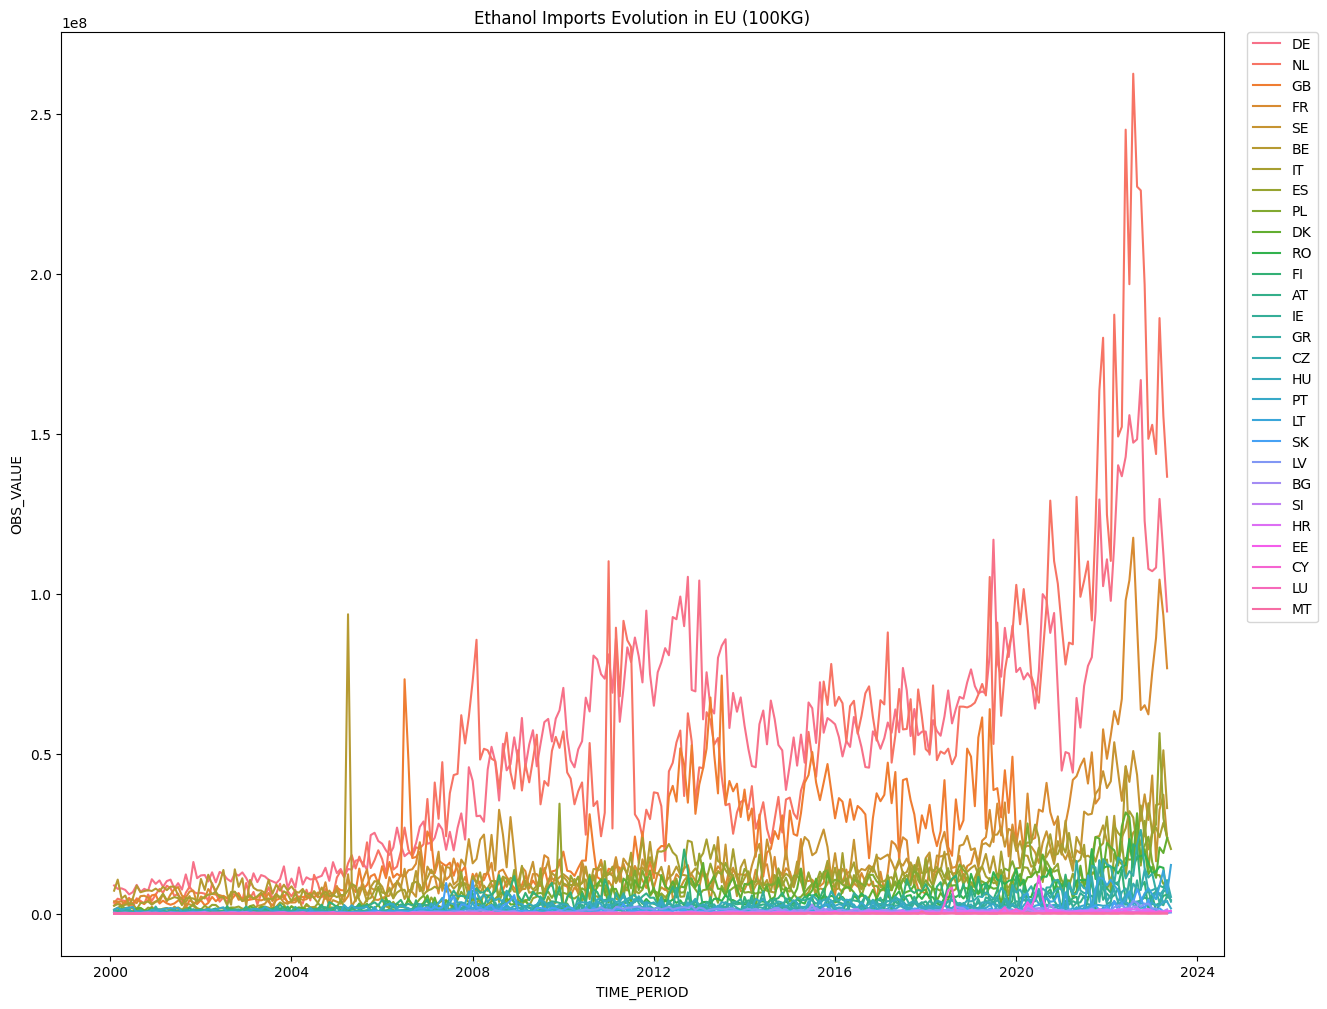

In [16]:
fig, ax =plt.subplots(figsize=(15,12))

plot_df = df[df.TIME_PERIOD > '2000'].dropna().groupby(['reporter', 'product', 'TIME_PERIOD'], as_index=False).OBS_VALUE.sum()

# order countries by last value
sorted_values = plot_df.groupby(['reporter'], as_index=False).OBS_VALUE.mean() \
                .sort_values('OBS_VALUE', ascending=False).reporter

sns.lineplot(plot_df, x='TIME_PERIOD', y='OBS_VALUE', hue = 'reporter', hue_order=sorted_values, ax=ax)

plt.title("Ethanol Imports Evolution in EU (100KG)")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

**Conclusions**:
* There was a huge rise between 2006 - 2010: will analyse total of imports since 2010
* Most of the countries wiht higher values are those with less missing values (except GB and SE): should look into those

In [18]:
timeframe = "2010"

## Geographic Plot

In [26]:
def get_countries():
    # read geodata europe
    countries = gpd.read_file("Datasets/NUTS_RG_20M_2021_3035/NUTS_RG_20M_2021_3035.shp") 
    # level 0 indicates contries
    countries = countries[countries['LEVL_CODE'] == 0]
    return countries

def plot_countries(countries):
    ax = countries.plot()
    # cut out islands form the plot
    ax.set_xlim(2000000, 8000000)
    ax.set_ylim(1000000, 5500000)
    
def get_geometry(data, on="geo"):
    countries = get_countries()
    gdf = gpd.GeoDataFrame(data.merge(countries[['NUTS_ID', 'geometry']].rename(columns={'NUTS_ID':'geo'}), 
                                          left_on=on, right_on = "geo", how='left'))
    return gdf

In [27]:
products = {
    'Ethanol' : '2207', 
    'LA': '291811', 
    'SA': '29171920'
}

In [53]:
df = df.rename(columns= {'product':'products'})
df.loc[df.reporter == 'GB', 'reporter'] = "UK"

Countries:  ['DE', 'NL', 'UK', 'FR', 'SE', 'IT', 'BE', 'DK', 'PL', 'ES'] Total Disposed Waste: 3.285715e+10 Tons
Values   :  [11492461094.0, 11207846092.0, 3672569755.0, 3520157812.0, 2964111525.0, 2170961316.0, 2068771943.0, 1522665247.0, 1496032862.0, 1449189642.0]



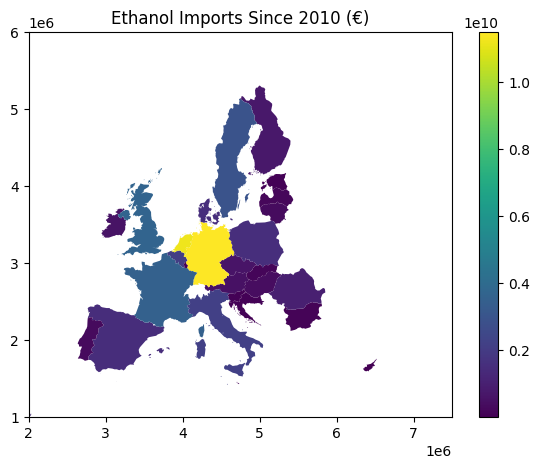

In [54]:
def plot_imports(key):
    plot_df = df[(df.TIME_PERIOD >= timeframe) & (df.products == products[key])].groupby("reporter", as_index = False).OBS_VALUE.sum()

    plot_df = get_geometry(plot_df, on="reporter").copy()

    # Create the map plot
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    plot_df.plot(column='OBS_VALUE', legend=True, ax=ax)
    ax.set_xlim(2000000, 7500000)
    ax.set_ylim(1000000, 6000000)

    plot_df = plot_df.sort_values('OBS_VALUE', ascending=False)
    ax.set_title(f"{key} Imports Since 2010 (€)")

    print(f'Countries: ', list(plot_df.head(10).reporter), f'Total Disposed Waste: {"{:e}".format(plot_df.head().OBS_VALUE.sum())} Tons')
    print(f'Values   : ', list(plot_df.head(10).OBS_VALUE))
    print()

    # Show the plot
    plt.show()

plot_imports('Ethanol')

Countries:  ['NL', 'DE', 'ES', 'BE', 'IT', 'FR', 'PL', 'UK', 'IE', 'GR'] Total Disposed Waste: 1.906319e+09 Tons
Values   :  [494266301.0, 460992403.0, 409610008.0, 279045212.0, 262404754.0, 251427914.0, 116887012.0, 97426489.0, 46505379.0, 45296298.0]



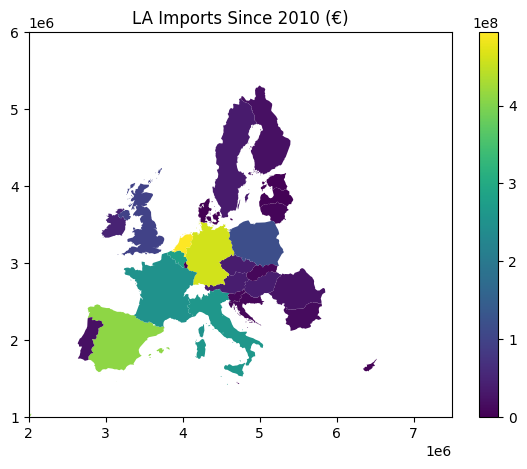

In [55]:
plot_imports('LA')

Countries:  ['DE', 'NL', 'IT', 'BE', 'FR'] Total Disposed Waste: 3.711599e+07 Tons
Values   :  [13378842.0, 7904543.0, 7214196.0, 4434680.0, 4183732.0]



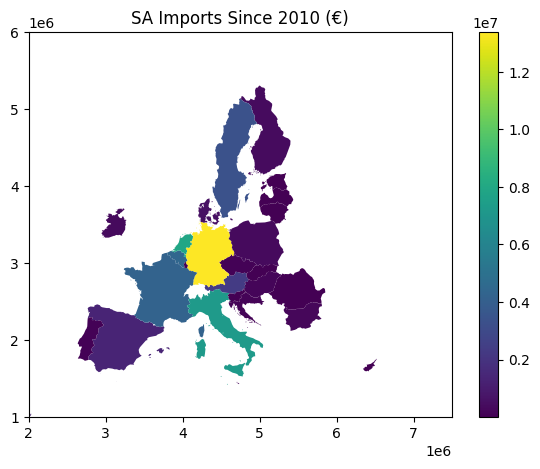

In [50]:
plot_imports('SA')

## Export Time Series

In [69]:
filters  = {
    "reporter" : ["DE"],
    "indicators" : ["QUANTITY_IN_100KG", "VALUE_IN_EUROS"]
}


for col in filters.keys():
    new_filter_pars[col] = filters[col]
    
new_filter_pars

{'freq': 'M',
 'reporter': ['DE'],
 'product': '2207',
 'indicators': ['QUANTITY_IN_100KG', 'VALUE_IN_EUROS'],
 'partner': ['WORLD'],
 'flow': ['1']}

In [81]:
ts_data = eurostat.get_data_df(code, format = "obs-row", filter_pars = new_filter_pars)
print(ts_data.shape)
ts_data.head()

(864, 8)


,freq,reporter,partner,product,flow,indicators,TIME_PERIOD,OBS_VALUE
0,M,DE,WORLD,2207,1,QUANTITY_IN_100KG,1988-01,26854.0
1,M,DE,WORLD,2207,1,VALUE_IN_EUROS,1988-01,1442300.0
2,M,DE,WORLD,2207,1,QUANTITY_IN_100KG,1988-02,41952.0
3,M,DE,WORLD,2207,1,VALUE_IN_EUROS,1988-02,2012402.0
4,M,DE,WORLD,2207,1,QUANTITY_IN_100KG,1988-03,43269.0


In [97]:
ts = ts_data[["indicators", "TIME_PERIOD", "OBS_VALUE"]]
ts = ts.pivot(columns="indicators", index="TIME_PERIOD", values="OBS_VALUE")
ts.columns.name = None
ts.loc[:, "QTY_TONS"] = ts["QUANTITY_IN_100KG"] / 10
ts.loc[:, "VALUE_1000€"] = ts["VALUE_IN_EUROS"] / 1000
ts.loc[:, "PRICE_€KG"] = ts["VALUE_1000€"] / ts["QTY_TONS"]
ts = ts[["QTY_TONS", "VALUE_1000€", "PRICE_€KG"]]
print(ts.shape)
ts

(432, 3)


,QTY_TONS,VALUE_1000€,PRICE_€KG
TIME_PERIOD,,,
1988-01,2685.4,1442.3,0.537089
1988-02,4195.2,2012.402,0.479692
1988-03,4326.9,2296.841,0.530828
1988-04,3629.1,1858.971,0.51224
1988-05,5547.2,2682.168,0.483517
...,...,...,...
2023-08,NaN,NaN,NaN
2023-09,NaN,NaN,NaN
2023-10,NaN,NaN,NaN


In [103]:
ts[ts.isna().any(axis=1)]

,QTY_TONS,VALUE_1000€,PRICE_€KG
TIME_PERIOD,,,
2023-05,NaN,NaN,NaN
2023-06,NaN,NaN,NaN
2023-07,NaN,NaN,NaN
2023-08,NaN,NaN,NaN
2023-09,NaN,NaN,NaN
2023-10,NaN,NaN,NaN
2023-11,NaN,NaN,NaN
2023-12,NaN,NaN,NaN


In [104]:
ts = ts[~ts.isna().any(axis=1)]

In [105]:
ts.to_pickle("ts_ethanol.pickle")

In [65]:
ts = df[df.reporter == reporter]
ts.head()

,reporter,partner,product,flow,indicators,TIME_PERIOD,OBS_VALUE,flags
3340,DE,WORLD,2207,1,QUANTITY_IN_100KG,1988-01-01,26854.0,
13347,DE,WORLD,2207,1,QUANTITY_IN_100KG,1988-02-01,41952.0,
23354,DE,WORLD,2207,1,QUANTITY_IN_100KG,1988-03-01,43269.0,
33361,DE,WORLD,2207,1,QUANTITY_IN_100KG,1988-04-01,36291.0,
43368,DE,WORLD,2207,1,QUANTITY_IN_100KG,1988-05-01,55472.0,


In [310]:
aux[(aux.partner == 'WORLD') & (aux.reporter == 'EU') & (aux["indicators"] == 'QUANTITY_IN_100KG') & aux.OBS_VALUE.isna()].TIME_PERIOD.unique()

array(['1999-01', '1999-02', '1999-03', '1999-04', '1999-05', '1999-06',
       '1999-07', '1999-08', '1999-09', '1999-10', '1999-11', '1999-12',
       '2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06',
       '2000-07', '2000-08', '2000-09', '2000-10', '2000-11', '2000-12',
       '2001-01', '2001-02', '2001-03', '2001-04', '2001-05', '2001-06',
       '2001-07', '2001-08', '2001-09', '2001-10', '2001-11', '2001-12',
       '2002-01', '2002-02', '2002-03', '2002-04', '2002-05', '2002-06',
       '2002-07', '2002-08', '2002-09', '2002-10', '2002-11', '2002-12',
       '2003-01', '2003-02', '2003-03', '2003-04', '2003-05', '2003-06',
       '2003-07', '2003-08', '2003-09', '2003-10', '2003-11', '2003-12',
       '2004-01', '2004-02', '2004-03', '2004-04', '2004-05', '2004-06',
       '2004-07', '2004-08', '2004-09', '2004-10', '2004-11', '2004-12',
       '2005-01', '2005-02', '2005-03', '2005-04', '2005-05', '2005-06',
       '2005-07', '2005-08', '2005-09', '2005-10', 

**Conclusions:**

* Data is being reported until 2023-12 while we are still at 2023-07. Data wil lbe stripped until the first quarter (2023-3)

In [247]:
melted_data = melted_data[melted_data.TIME_PERIOD < '2023-04-01']
melted_data[melted_data.TIME_PERIOD == melted_data.TIME_PERIOD.max()].isna().sum()

reporter       0
flow           0
TIME_PERIOD    0
OBS_VALUE      7
dtype: int64

## Missing Values

Missing Values per contry and flow

In [248]:
@interact
def plot_nas(Fields = ['reporter', 'flow']):
    df = melted_data.groupby(Fields).OBS_VALUE.apply(lambda x: x.isna().sum()).sort_values(ascending=False)
    ax = sns.barplot(x=df.values, y=df.index , palette='pastel', saturation=0.85)
    ax.bar_label(ax.containers[0])
    field = 'Country' if Fields == 'reporter' else 'Flow'
    ax.set(ylabel=field,
           xlabel="Missing Observations",
          title=f"Missing Observations Per {field}")
    sns.despine()

interactive(children=(Dropdown(description='Fields', options=('reporter', 'flow'), value='reporter'), Output()…

Missing values per time period

In [ ]:
@interact
def plot_nas(Fields = ['all', 'reporter', 'flow']):
    if Fields == 'all':
        df = melted_data.groupby('TIME_PERIOD').OBS_VALUE.apply(lambda x: x.isna().sum()).sort_values(ascending=False)
    else:
        df = melted_data.groupby(['TIME_PERIOD', Fields]).OBS_VALUE.apply(lambda x: x.isna().sum()).sort_values(ascending=False)
    
    ax = sns.barplot(x=df.values, y=df.index , palette='pastel', saturation=0.85)
    ax.bar_label(ax.containers[0])
    field = 'Country' if Fields == 'reporter' else 'Flow'
    ax.set(ylabel=field,
           xlabel="Missing Observations",
          title=f"Missing Observations Per Month ({field})")
    sns.despine()

# Tests

Custom dataset created:
* Reporter: All indiviudal 28 countries (EU27 + UK) 
* Partner: World (all countries)
* Indicator: Qunatity (100 KG)
* Flow: 1 (Imports) + 2 (Exports)
* Frequency: Monthly
* Time_Period: only months (since 1988)

In [25]:
df = melted_data[(melted_data.indicators == 'QUANTITY_IN_100KG') & (melted_data.reporter == 'DE') & (melted_data.partner == 'WORLD') & (melted_data.flow == '2')].drop(['partner', 'indicators', 'reporter', 'flow'],axis = 1).set_index('TIME_PERIOD')
df.head()

,OBS_VALUE
TIME_PERIOD,
1988-01-01,27411.0
1988-02-01,44108.0
1988-03-01,41559.0
1988-04-01,34977.0
1988-05-01,40197.0


In [26]:
df[df.OBS_VALUE.isna()]

,OBS_VALUE
TIME_PERIOD,
2023-05-01,NaN
2023-06-01,NaN
2023-07-01,NaN
2023-08-01,NaN
2023-09-01,NaN
2023-10-01,NaN
2023-11-01,NaN
2023-12-01,NaN


In [27]:
df = df[~df.OBS_VALUE.isna()]

In [46]:
df.to_csv('test_timeseries.csv')

<Axes: title={'center': 'Export Volume Germany of Ethanol (100Kg)'}, xlabel='TIME_PERIOD'>

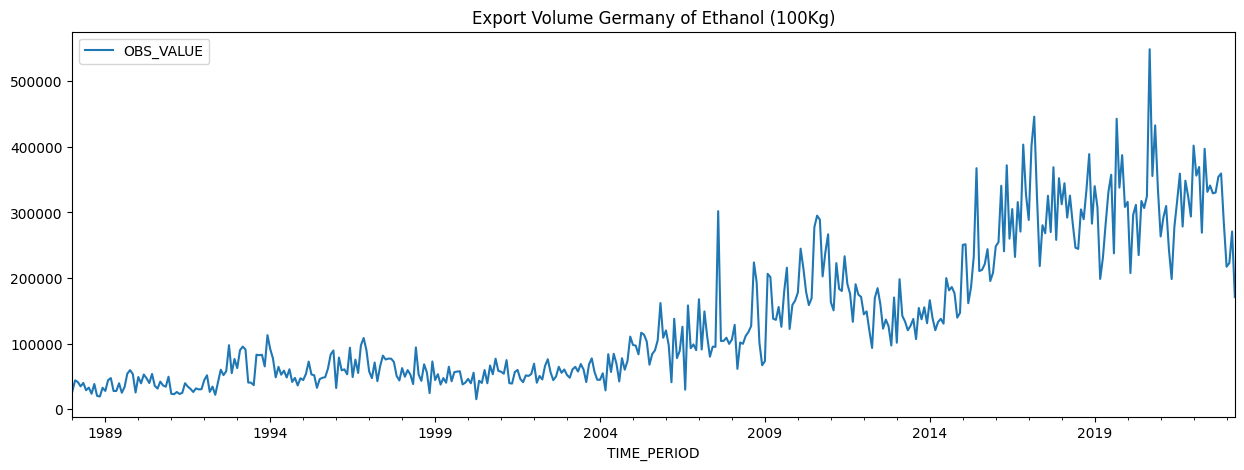

In [28]:
df.plot(style='-', figsize=(15,5), title = "Export Volume Germany of Ethanol (100Kg)")

## Is the Time Series Stationary?

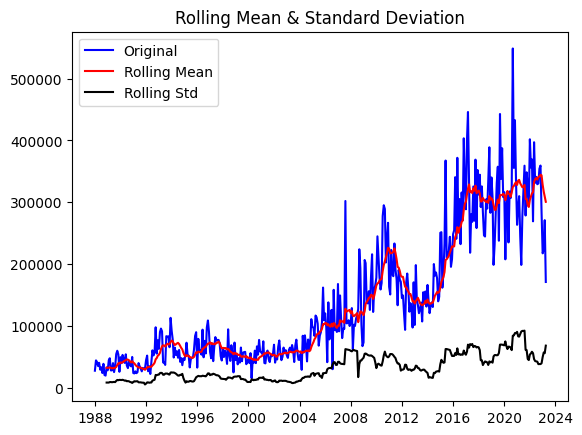

ADF Statistic: -0.6648899709762983
p-value: 0.8556354674800539
Critical Values:
	1%: -3.4462831955497135
	5%: -2.8685636962704395
	10%: -2.5705114078759914


In [29]:
def get_stationarity(timeseries, y = 'OBS_VALUE'):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries[y])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
               
get_stationarity(df.dropna())

not stationarary

### "Stationarizing the data"
Taking the log of the dependent variable is as simple way of lowering the rate at which rolling mean increases. 

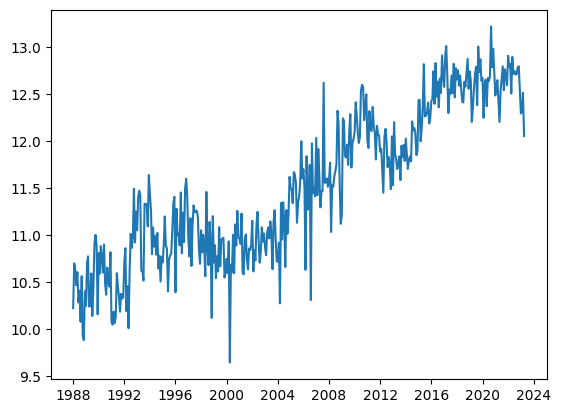

In [30]:
df_log = np.log(df)
plt.plot(df_log)

Then we can test different data ransformatons to "stationarize the data":
1. Subtracting the rolling mean
2. Exponential decay
3. Time shifting

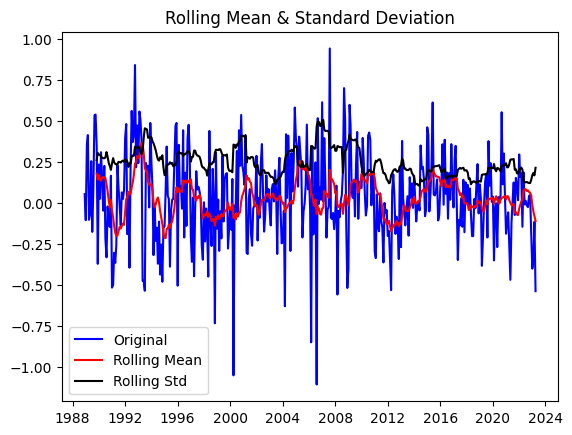

ADF Statistic: -11.30604154549582
p-value: 1.272605541222289e-20
Critical Values:
	1%: -3.4463612216221775
	5%: -2.8685980017932917
	10%: -2.5705296947685605


In [31]:
# Subtracting the rolling mean
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

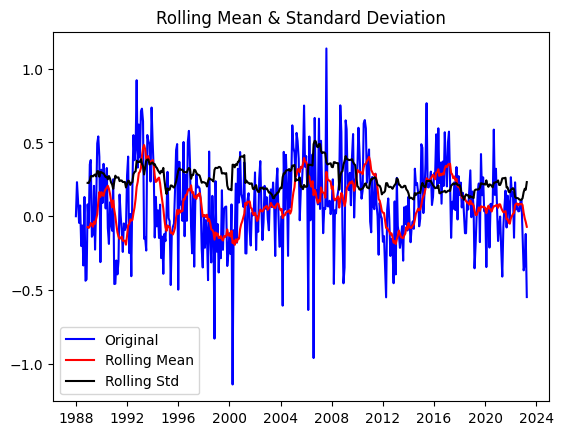

ADF Statistic: -5.022259585688845
p-value: 2.0048672079346723e-05
Critical Values:
	1%: -3.4460914174990296
	5%: -2.868479374038333
	10%: -2.570466459559076


In [32]:
# Exponential decay
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

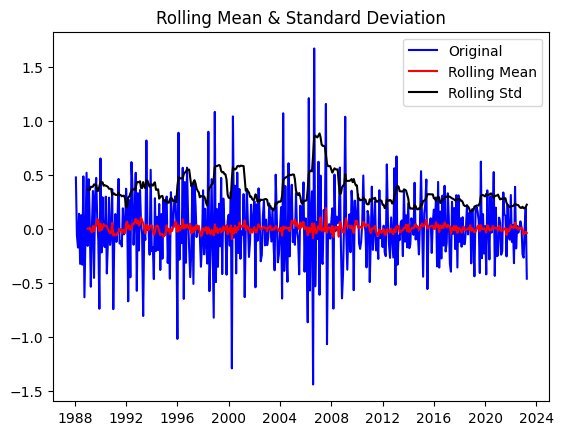

ADF Statistic: -11.991390551055623
p-value: 3.5143603897021333e-22
Critical Values:
	1%: -3.4461675720270404
	5%: -2.8685128587855955
	10%: -2.5704843086630915


In [33]:
# Time shift
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

**Time Shift performed the best**

# ARIMA model

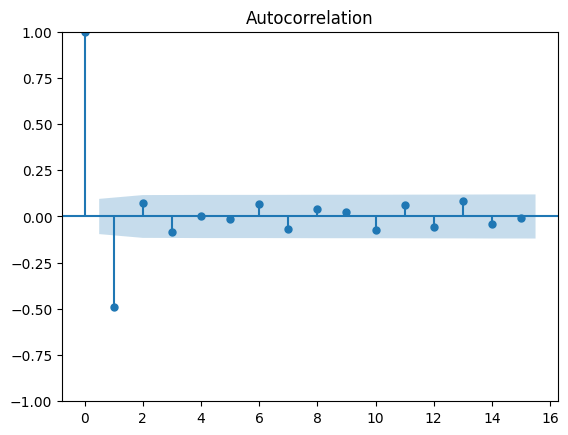

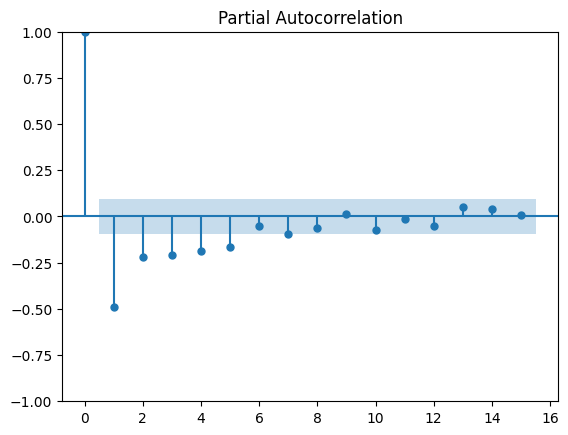

In [34]:
# Draw ACF and PACF plots

sm.graphics.tsa.plot_acf(df_log_shift['OBS_VALUE'], lags = 15) # Select AR order
sm.graphics.tsa.plot_pacf(df_log_shift['OBS_VALUE'], lags = 15) # Select MA order
plt.xticks()
plt.show()

C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


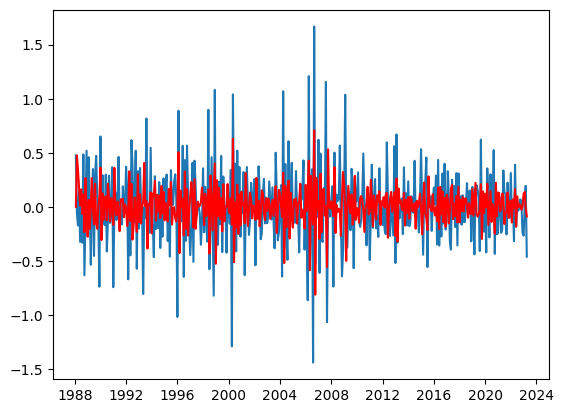

In [62]:
decomposition = seasonal_decompose(df_log_shift) 
model = ARIMA(df_log_shift, order=(1,1,1)) 
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

Text(0.5, 1.0, 'ARIMA Results vs. Real Volume')

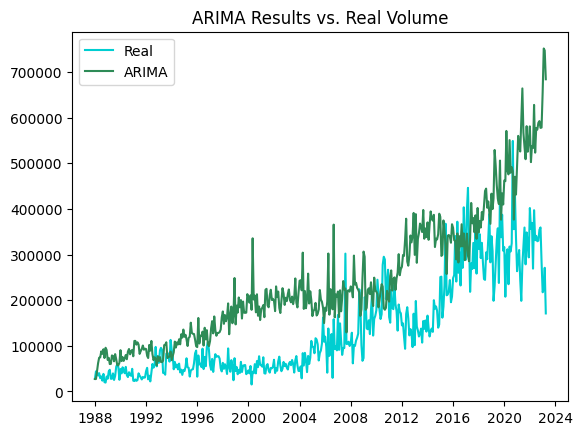

In [63]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['OBS_VALUE'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df, label = "Real", color = "darkturquoise")
plt.plot(predictions_ARIMA, label = "ARIMA", color = "seagreen")
plt.legend(loc='best')
plt.title('ARIMA Results vs. Real Volume')

* mean average percentage errror
* LSTM

<Axes: >

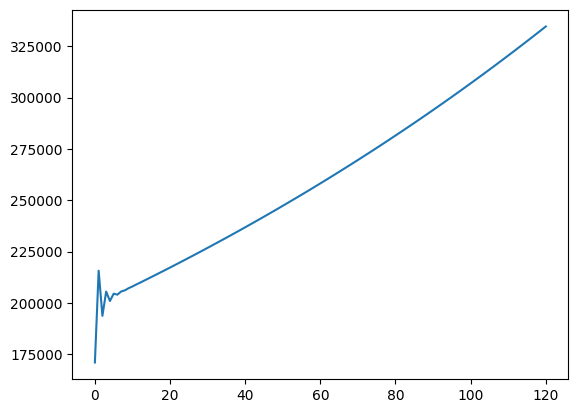

In [210]:
# Number of steps to forecast
n_steps = 120

# Forecast
forecast = results.forecast(steps=n_steps)

# Reverse the differencing
forecast_reversed = np.r_[df_log.iloc[-1], forecast].cumsum()

# Reverse the log transformation
forecast_reversed = np.exp(forecast_reversed)
pd.Series(forecast_reversed).plot()

In [217]:
#df = df.drop('forcast_SARIMA_1', axis = 1)
df.tail()

,OBS_VALUE
TIME_PERIOD,
2022-12-01,283449.36
2023-01-01,217277.89
2023-02-01,222961.62
2023-03-01,270905.33
2023-04-01,170948.46


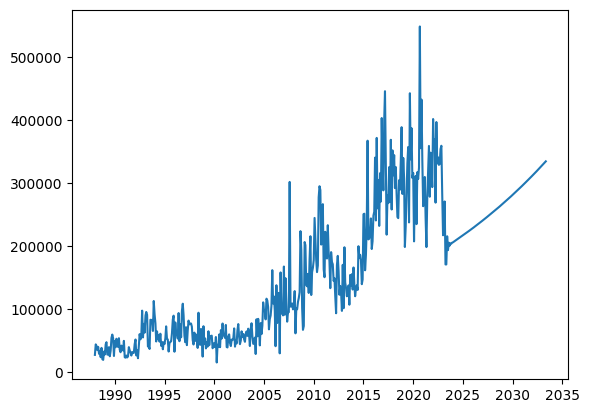

In [225]:
start = datetime.datetime.strptime("2023-05-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,121)]
future = pd.DataFrame(forecast_reversed, index=date_list, columns= df.columns)
future_prediction = pd.concat([df, future])
plt.plot(future_prediction)

In [179]:
predictions_ARIMA_log = pd.Series(df_log['OBS_VALUE'].iloc[0], index=df_log.index)
predictions_ARIMA_log

TIME_PERIOD
1988-01-01    10.2187
1988-02-01    10.2187
1988-03-01    10.2187
1988-04-01    10.2187
1988-05-01    10.2187
               ...   
2022-12-01    10.2187
2023-01-01    10.2187
2023-02-01    10.2187
2023-03-01    10.2187
2023-04-01    10.2187
Length: 424, dtype: float64

In [180]:
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log

TIME_PERIOD
1988-01-01    10.218700
1988-02-01    10.218700
1988-03-01    10.694396
1988-04-01    11.033782
1988-05-01    11.209997
                ...    
2022-12-01    13.267439
2023-01-01    13.391848
2023-02-01    13.529402
2023-03-01    13.523579
2023-04-01    13.435341
Length: 424, dtype: float64

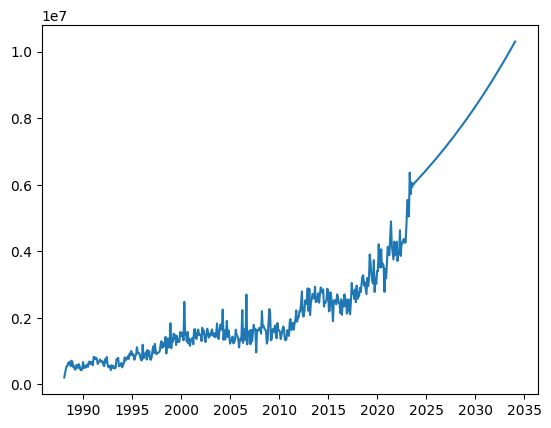

In [186]:
plt.plot(np.exp(pd.Series(results.predict(start=0, end=552)).cumsum() + predictions_ARIMA_log.mean()))

In [176]:
predictions_ARIMA_diff
np.exp(predictions_ARIMA_diff_cumsum)


TIME_PERIOD
1988-02-01     1.000000
1988-03-01     1.609135
1988-04-01     2.259363
1988-05-01     2.694729
1988-06-01     2.727975
                ...    
2022-12-01    21.088743
2023-01-01    23.882568
2023-02-01    27.404356
2023-03-01    27.245266
2023-04-01    24.944202
Length: 423, dtype: float64

In [204]:
model = sm.tsa.statespace.SARIMAX(df.dropna()['OBS_VALUE'],order=(2,1,2),seasonal_order=(2,1,2,6))
result=model.fit()

C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


LinAlgError: Schur decomposition solver error.

<Axes: xlabel='TIME_PERIOD'>

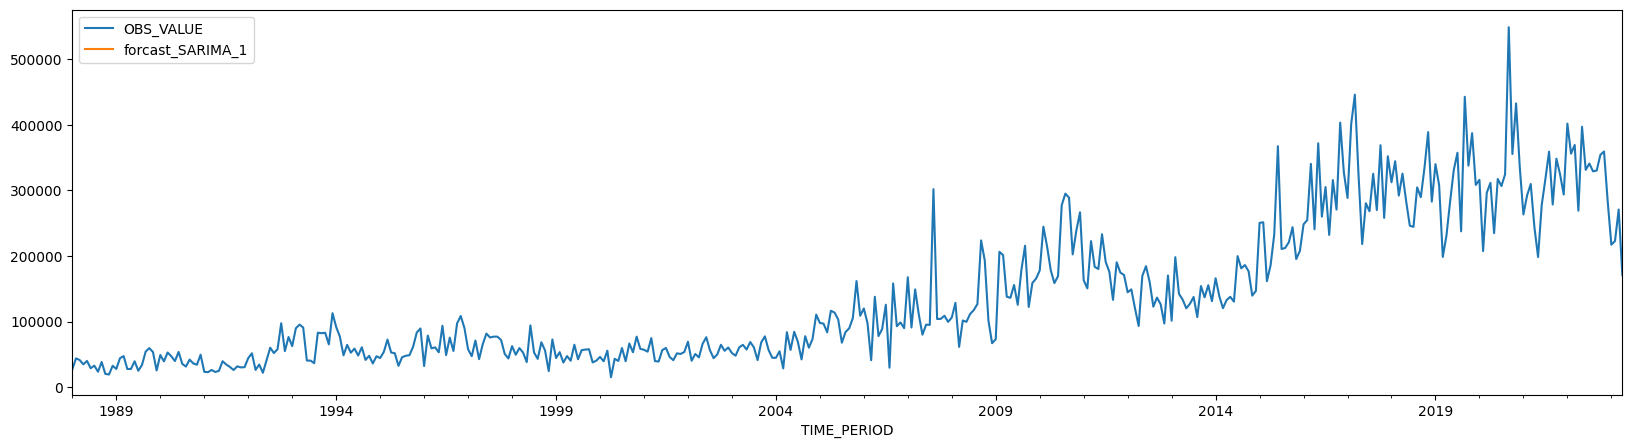

In [199]:
df['forcast_SARIMA_1']=result.predict(start=350, end=552)
df[['OBS_VALUE','forcast_SARIMA_1']].plot(figsize=(20, 5))

In [200]:
import datetime
from dateutil.relativedelta import relativedelta
start = datetime.datetime.strptime("2023-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,120)]
future_prediction = pd.DataFrame(index=date_list, columns= df.columns)
data = pd.concat([df, future_prediction])

C:\Users\digval\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


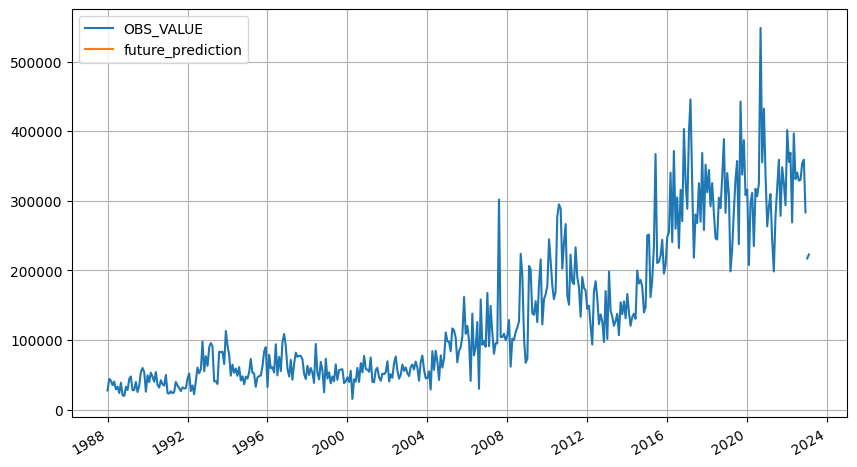

In [201]:
data['future_prediction']=result.predict(start=430, end=552, dynamic=True)
data[['OBS_VALUE','future_prediction']].plot(figsize=(10, 6))
plt.grid(True)

# Train / Test Split

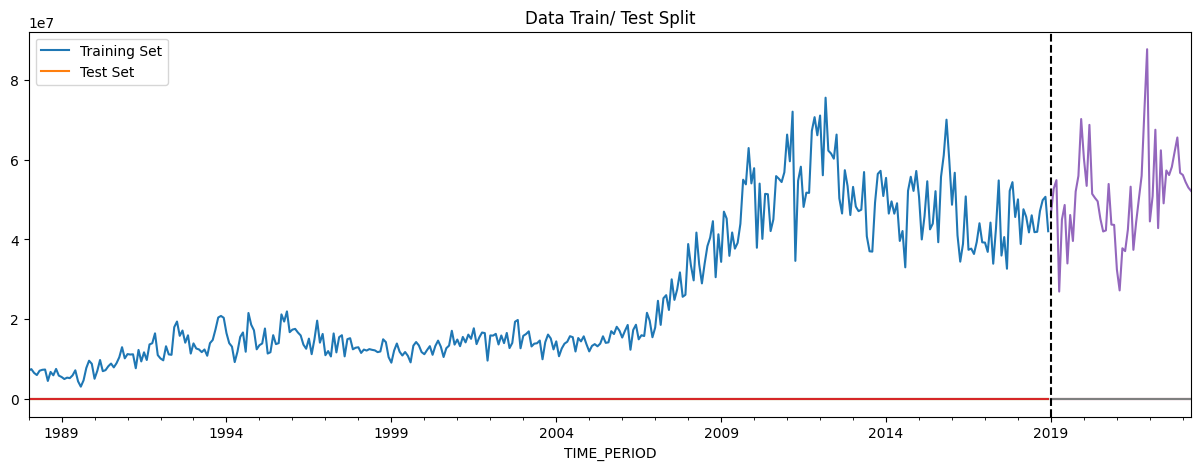

In [31]:
df = df.dropna()
train = df.loc[df.index < '2019-01']
test = df.loc[df.index >= '2019-01']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
ax.axvline('2019-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_title('Data Train/ Test Split')
plt.show()

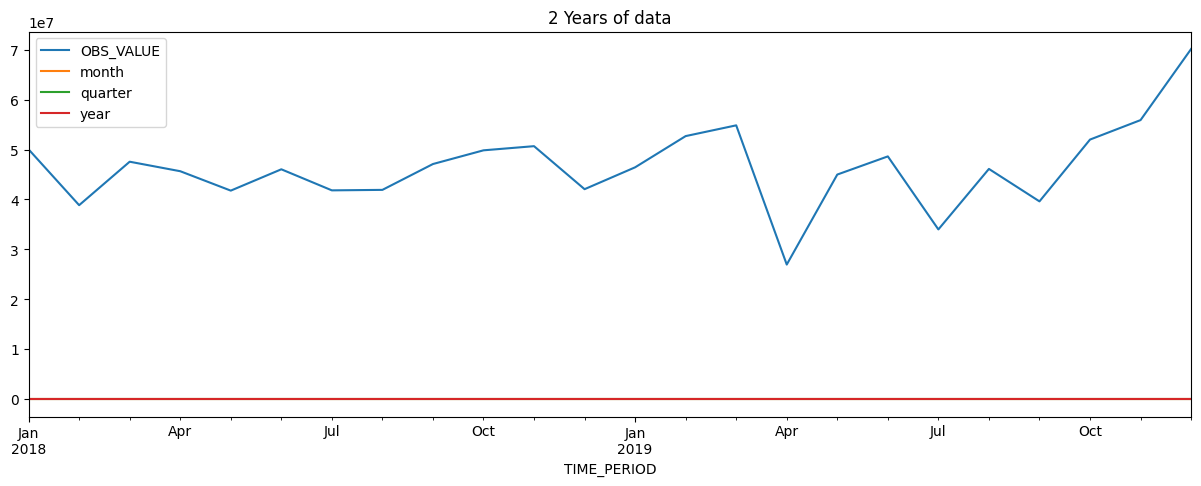

In [32]:
df.loc[(df.index >= '2018-01-01') & (df.index < '2020-01-01')].plot(figsize=(15, 5), title="2 Years of data")
plt.show()

# Feature Creation

In [33]:
def create_features(df):
    """
    Create time series features based on time series index
    """
    df = df.copy()
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    
    return df


In [34]:
df = create_features(df)

# Visualize our Feature / Target Relationships

<Axes: xlabel='month', ylabel='OBS_VALUE'>

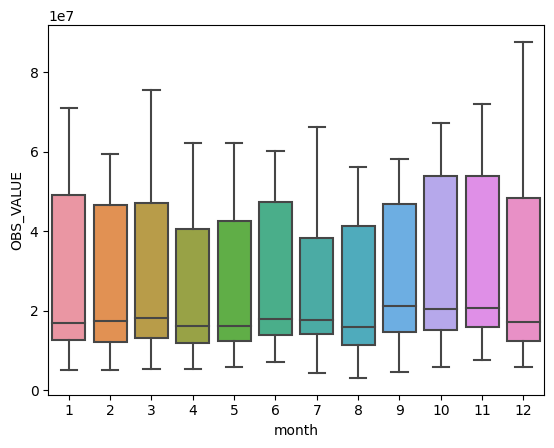

In [35]:
sns.boxplot(data=df, x='month', y='OBS_VALUE')

# Create Model

In [36]:
train = create_features(train)
test = create_features(test)

FEATURES = ['month', 'quarter', 'year']
TARGET = 'OBS_VALUE'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [40]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate = 0.001)
reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:31392207.30715	validation_1-rmse:52029055.75170
[100]	validation_0-rmse:28547455.12165	validation_1-rmse:47580637.50799
[200]	validation_0-rmse:25979018.17428	validation_1-rmse:44051426.80141
[300]	validation_0-rmse:23660409.67298	validation_1-rmse:40875920.37163
[400]	validation_0-rmse:21569219.80156	validation_1-rmse:38015758.87628
[500]	validation_0-rmse:19681970.95234	validation_1-rmse:35372755.76400
[600]	validation_0-rmse:17976583.65334	validation_1-rmse:32912099.44336
[700]	validation_0-rmse:16437842.00266	validation_1-rmse:30735905.25328
[800]	validation_0-rmse:15049724.38166	validation_1-rmse:28800629.17619
[900]	validation_0-rmse:13797483.57424	validation_1-rmse:27067114.80694
[999]	validation_0-rmse:12682799.28772	validation_1-rmse:25503559.08117


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Feature Importance

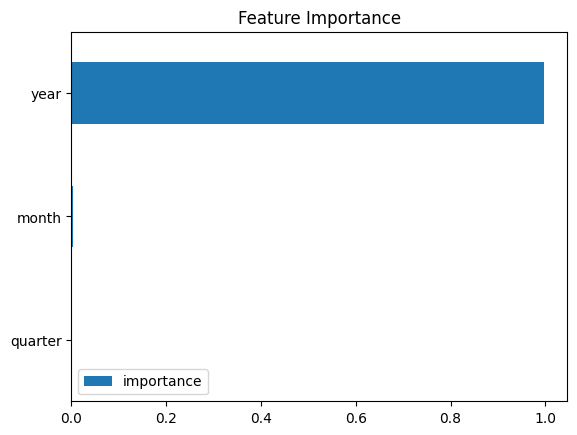

In [43]:
fi= pd.DataFrame(data = reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

In [44]:
test['prediction'] = reg.predict(X_test)

In [45]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

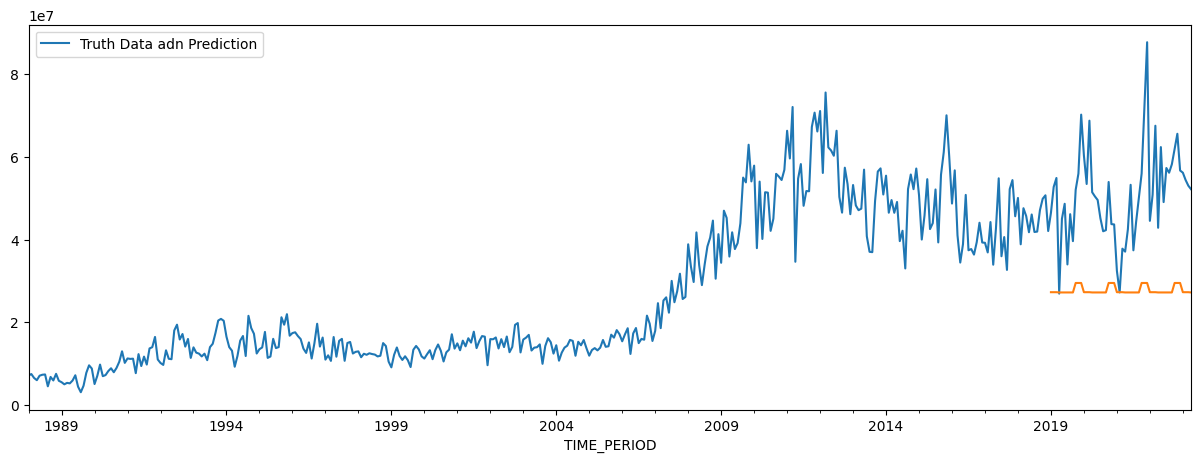

In [48]:
ax = df[['OBS_VALUE']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data adn Prediction'])
plt.show()

# Auxiliary Analysis

## Comparting Eurostat Package to Direct Download

**1. Direct Download**

Downloaded linear .csv table from [Eurostat Trade Data](https://ec.europa.eu/eurostat/databrowser/view/DS-045409/default/table?lang=en), with following filters:
* Reporter: All indiviudal 28 countries (EU27 + UK) 
* Partner: World (all countries)
* Indicator: Value (€)
* Flow: 1 (Imports) + 2 (Exports)
* Frequency: Monthly
* Time_Period: only months (since 1988)

In [256]:
df_download = pd.read_csv("Datasets/trade_ethanol_linear.csv")

for col in df_download.columns:
    if len(df_download[col].unique()) < 2:
        print(f'Deleted {col}, with value {df_download.loc[0, col]}')
        df_download = df_download.drop(col, axis = 1)
        
df_download

Deleted DATAFLOW, with value ESTAT:DS-045409(1.0)
Deleted LAST UPDATE, with value 14/07/23 11:00:00
Deleted freq, with value M
Deleted partner, with value WORLD
Deleted product, with value 2207
Deleted indicators, with value VALUE_IN_EUROS
Deleted OBS_FLAG, with value nan


,reporter,flow,TIME_PERIOD,OBS_VALUE
0,AT,1,1995-01,110778
1,AT,1,1995-02,164662
2,AT,1,1995-03,860014
3,AT,1,1995-04,417208
4,AT,1,1995-05,375613
...,...,...,...,...
17948,SK,2,2022-12,9716405
17949,SK,2,2023-01,3617440
17950,SK,2,2023-02,22584273
17951,SK,2,2023-03,4597452


In [257]:
df_download.shape
df_download.isna().sum()

reporter       0
flow           0
TIME_PERIOD    0
OBS_VALUE      0
dtype: int64

In [259]:
@interact
def unique(Fields = df_download.columns):
    print(df_download[Fields].unique())


interactive(children=(Dropdown(description='Fields', options=('reporter', 'flow', 'TIME_PERIOD', 'OBS_VALUE'),…

**2. Eurostat Package**

Testing package [Eurostat](https://pypi.org/project/eurostat/), with following filters:
* Reporter: All indiviudal 28 countries (EU27 + UK) 
* Partner: World (all countries)
* Indicator: Value (€)
* Flow: 1 (Imports) + 2 (Exports)
* Frequency: Monthly
* Time_Period: only months (since 1988)

Table code (taken from [Eurostat Trade Data](https://ec.europa.eu/eurostat/databrowser/view/DS-045409/default/table?lang=en)): DS-045409

In [61]:
code = 'DS-045409'

In [63]:
# try to get full table
try:
    df_package = eurostat.get_data_df(code)
    print(df_package.shape)
except Exception as e:
    print("An error occurred:", e)

faultcode: 413
faultstring: EXTRACTION_TOO_BIG_COMEXT: The requested extraction is too big. Full extraction of COMEXT datasets is forbidden, please add filters to reduce the extraction size
An error occurred: 413 Client Error: Request Entity Too Large for url: https://ec.europa.eu/eurostat/api/comext/dissemination/sdmx/2.1/data/DS-045409?format=TSV&compressed=true


In [64]:
# get table columns (parameters)
pars = eurostat.get_pars(code)
pars

['freq', 'reporter', 'partner', 'product', 'flow', 'indicators']

In [67]:
@interact
def unique(Select_Column=pars): 
    print(f'Unique {Select_Column} values:')
    # print unique values (maximum 50)
    print(eurostat.get_par_values(code, Select_Column)[:50])

interactive(children=(Dropdown(description='Select_Column', options=('freq', 'reporter', 'partner', 'product',…

In [68]:
# Filter
my_filter_pars = {
    # Months
    'freq': 'M',
    # Individual Countries
    'reporter' : ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES',
       'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV',
       'MT', 'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK'], 
    # World
    'partner' : 'WORLD',
    # Select ethanol code
    'product' : '2207', 
    # Flow doesnt need filtering
    #'flow', 
    'indicators': 'VALUE_IN_EUROS'
}

df_package = eurostat.get_data_df(code, filter_pars=my_filter_pars)
df_package.shape

(56, 438)

In [21]:
df_package.head()

,freq,reporter,partner,product,flow,indicators\TIME_PERIOD,1988-01,1988-02,1988-03,1988-04,...,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
0,M,AT,WORLD,2207,1,VALUE_IN_EUROS,NaN,NaN,NaN,NaN,...,8023641.0,7647044.0,NaN,None,None,None,None,None,None,None
1,M,AT,WORLD,2207,2,VALUE_IN_EUROS,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,None,None,None,None,None,None
2,M,BE,WORLD,2207,1,VALUE_IN_EUROS,3040780.0,1819018.0,3853951.0,2622618.0,...,31384764.0,49255466.0,NaN,None,None,None,None,None,None,None
3,M,BE,WORLD,2207,2,VALUE_IN_EUROS,248127.0,259883.0,189551.0,172568.0,...,54253475.0,40371901.0,NaN,None,None,None,None,None,None,None
4,M,BG,WORLD,2207,1,VALUE_IN_EUROS,NaN,NaN,NaN,NaN,...,332481.0,575747.0,NaN,None,None,None,None,None,None,None


In [77]:
# Melt the DataFrame 
melted_df_package = df_package.drop(['freq', 'partner', 'product', 'indicators\TIME_PERIOD'], axis = 1).melt(id_vars=['reporter', 'flow'], var_name='TIME_PERIOD', value_name='OBS_VALUE')
melted_df_package

,reporter,flow,TIME_PERIOD,OBS_VALUE
0,AT,1,1988-01,NaN
1,AT,2,1988-01,NaN
2,BE,1,1988-01,3040780.0
3,BE,2,1988-01,248127.0
4,BG,1,1988-01,NaN
...,...,...,...,...
24187,SE,2,2023-12,None
24188,SI,1,2023-12,None
24189,SI,2,2023-12,None
24190,SK,1,2023-12,None


Eurostat package has more rows because it contains empty values

In [78]:
melted_df_package = melted_df_package.dropna().reset_index(drop=True)
melted_df_package

,reporter,flow,TIME_PERIOD,OBS_VALUE
0,BE,1,1988-01,3040780.0
1,BE,2,1988-01,248127.0
2,DE,1,1988-01,1442300.0
3,DE,2,1988-01,1370157.0
4,DK,1,1988-01,555768.0
...,...,...,...,...
17948,LT,2,2023-05,3383451.0
17949,LV,1,2023-05,205931.0
17950,LV,2,2023-05,681261.0
17951,PT,1,2023-05,3507589.0


Now both have the same number of values. But lets compare if the values are the same

In [92]:
df1 = melted_df_package.sort_values(['reporter','flow','TIME_PERIOD','OBS_VALUE']).reset_index(drop=True)
df1.head()
df2 = df_download.sort_values(['reporter','flow','TIME_PERIOD','OBS_VALUE']).reset_index(drop=True)
df2.head()

df1 == df2

,reporter,flow,TIME_PERIOD,OBS_VALUE
0,AT,1,1995-01,110778.0
1,AT,1,1995-02,164662.0
2,AT,1,1995-03,860014.0
3,AT,1,1995-04,417208.0
4,AT,1,1995-05,375613.0


,reporter,flow,TIME_PERIOD,OBS_VALUE
0,AT,1,1995-01,110778
1,AT,1,1995-02,164662
2,AT,1,1995-03,860014
3,AT,1,1995-04,417208
4,AT,1,1995-05,375613


,reporter,flow,TIME_PERIOD,OBS_VALUE
0,True,False,True,True
1,True,False,True,True
2,True,False,True,True
3,True,False,True,True
4,True,False,True,True
...,...,...,...,...
17948,True,False,True,True
17949,True,False,True,True
17950,True,False,True,True
17951,True,False,True,True


They seem to be the same but flow is giving different. Probably different dtypes

In [90]:
df1.dtypes
df2.dtypes

reporter       object
flow           object
TIME_PERIOD    object
OBS_VALUE      object
dtype: object

reporter       object
flow            int64
TIME_PERIOD    object
OBS_VALUE       int64
dtype: object

In [93]:
df1.flow = df1.flow.astype(int)
df1.OBS_VALUE = df1.OBS_VALUE.astype(int)

In [101]:
# Sum different values in each column (1st sum) and then sum those values (2nd sum)
(df1 != df2).sum().sum()

0

**DATA IS CONGRUENT**

eurostat package will be used